<div align="center">
  <img src="https://raw.githubusercontent.com/lapalap/dora/6991c4a08f27e4171e3a9b0bdffc0a14966e07df/assets/images/logo.svg" width="350"/>
</div>

<div align="center"><h1>DORA: Getting Started</h1>
<h5>Simple notebook to get you started with DORA package </h5>

In [1]:
! pip install umap-learn --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00


In [20]:
from dora import Dora
from dora.objectives import ChannelObjective

import torch
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm import tqdm

## 🔧 Set up a pre-trained model
DORA also supports your own custom models, but for this example we'll stick to a pre-trained one

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).eval().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 🧙Initiate DORA and select the neurons you'd want to investigate

In [12]:
d = Dora(model=model,
          storage_dir="dora/",
          device=device)

k = 512
neuron_indices = [i for i in range(0, k)]

## ⚡ Generate s-AMS
i.e Synthetic Activation Maximization Signals

In [ ]:
generate_sams = True

experiment_name = 'resnet18.avgpool'
n = 5

if generate_sams:
  d.generate_signals(
        neuron_idx=neuron_indices,
        num_samples = n,
        layer=model.avgpool,
        only_maximization = True,
        image_transforms = transforms.Compose([transforms.Pad(2, fill=.5, padding_mode='constant'),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine(0, translate=(0.015, 0.015), fill=0.5),
                                              transforms.RandomAffine((-20,20),
                                                                      scale=(0.75, 1.025),
                                                                      fill=0.5),
                                              transforms.RandomCrop((224, 224),
                                                                    padding=None,
                                                                    pad_if_needed=True,
                                                                    fill=0,
                                                                    padding_mode='constant')]),
        objective_fn=ChannelObjective(),
        lr=0.05,
        width=224,
        height=224,
        iters=500,
        experiment_name=experiment_name,
        overwrite_experiment=True,  ## will still use what already exists if generation params are same
    )
else:
  ! wget -O resnet18_avgpool.zip https://www.dropbox.com/s/c4of98hbjzti9r8/model.avgpool.zip
  ! mkdir dora/sAMS
  ! unzip resnet18_avgpool.zip -d dora/sAMS -q 


# 🔬Collect Encodings of s-AMS

First, we create a dataloader to efficiently inference s-AMS

In [23]:
from dora import SignalDataset

batch_size = 256

sams_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
                       ])

dataset = SignalDataset('/content/dora/sAMS/model.avgpool',
                        k = k,
                        n = n,
                        transform = sams_transforms)

testloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

Next, we create a hook on the network to collect activations

In [19]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

model.eval()
model.avgpool.register_forward_hook(get_activation('avgpool'))

Finally, we collect activations across average pooling layer of the network

In [25]:
A = torch.zeros([k,k,n]).to(device)

with torch.no_grad():
  for i, (x, metainfo) in tqdm(enumerate(testloader)):
      x = x.float().to(device)

      outputs = model(x)

      r_id = metainfo[0]
      sample_id = metainfo[1]
      A[r_id, :, sample_id] = activation['avgpool'].view([batch_size, 512])

10it [00:07,  1.42it/s]


# 📐 Compute EA distances

After collection of the embeddings of the s-AMS we can compute EA distance between representations

In [26]:
from dora import EA_distance

# average the encodings along samples
A = A.mean(axis = 2)

D = EA_distance(A, layerwise = True)

# ✨ Representation Atlas

Perform a dimensionality reduction and visualise representation space

In [28]:
import umap
umap_op = umap.UMAP(metric='precomputed')
data_umap = umap_op.fit_transform(D.cpu())

Visualise representation space of the average pooling layer of ResNet18. We highlight cluster of Chinese-watermark detector representations, found by DORA.

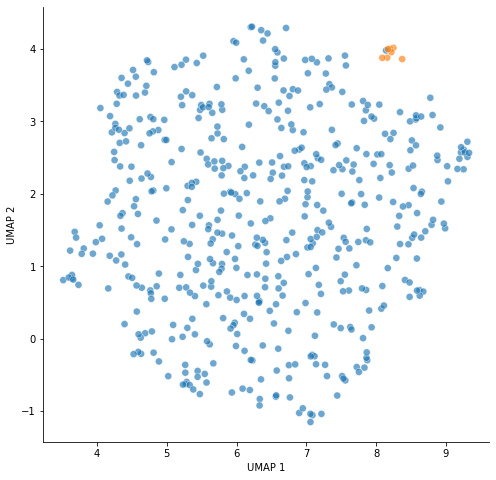

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

f, ax = plt.subplots(figsize=(8, 8))

CH_resps = [154, 489, 129, 347, 81, 439,282]

color = [1 if x in CH_resps else 0 for x in range(0, 512)]

data = pd.DataFrame(data_umap)
data.columns = ['x', 'y']
data['label'] = color

ax = sns.scatterplot(
    data=data, x="x", y="y", hue = 'label', s=50, alpha = 0.65, legend = False,
)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
sns.despine()

# 🔎 Investigate s-AMS

Visualise the s-AMS from the Chinese-character detector cluster and compare them with the s-AMS of other randomly selected representations.

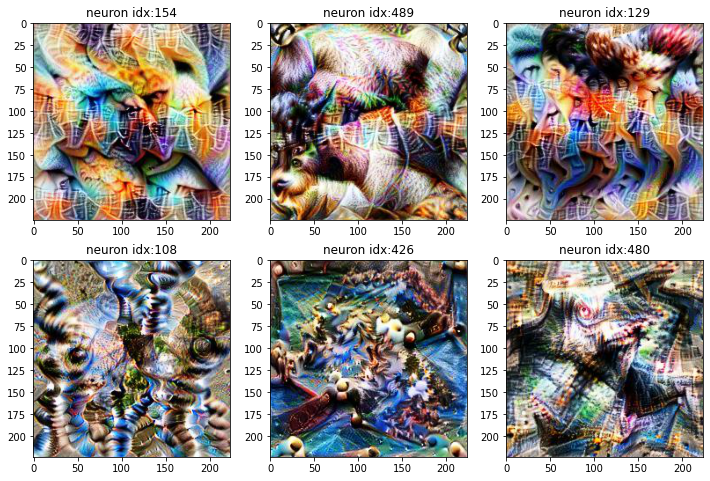

In [52]:
from PIL import Image
import random

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# top row -- Chinese-character detectors s-AMS
for i, col in enumerate(ax[0]):
  im = Image.open("/content/dora/sAMS/model.avgpool/{neuron_id}_1+.jpg".format(neuron_id = CH_resps[i]))
  col.imshow(im)
  col.set_title(f"neuron idx:{CH_resps[i]}")

# bottom row -- s-AMS of random representations
for i, col in enumerate(ax[1]):
  random_neuron = random.choice(neuron_indices)
  im = Image.open("/content/dora/sAMS/model.avgpool/{neuron_id}_1+.jpg".format(neuron_id = random_neuron))
  col.imshow(im)
  col.set_title(f"neuron idx:{random_neuron}")

plt.show()

# 👀 Run Outlier Detection



In [65]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(metric = 'precomputed', contamination = 0.01)
outliers = clf.fit_predict(D.cpu())

p = torch.tensor(clf.negative_outlier_factor_)